$$
H_s = -\sum_i J s^z_i s^z_{i+1} - \sum_i (h_x s^x_i + h_z s^z_i)
$$
The spins in the system hamiltonian $H_s$ are coupled to bath spins $\sigma_i$ such that the whole hamiltonian is as follows
$$
H = H_s + \sum_{i=1}^L [J_c(t)s_i^z \sigma^z_i - B(t)\sigma_i^z + h_b \sigma_i^x] 
$$
The function $B(t)$ represents the Zeeman field acting on the bath spins and $J_c(t)$ is the strength of the system-bath coupling. The protocol is performed in cycles. The bath spins begin each one in a fully polarized state and are reset at the beginning of a new cycle. 



In [47]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline
sns.set_style("whitegrid")



In [48]:
# Pauli matricies

si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

In [49]:
end_of_cycle_measurement = False          # Meritev spinov v sigma^z bazi po koncu vsakega cikla
pass_directly_with_added_errors = False 
remake_product_state = False
remake_product_state_LSQ = False 
open_dynamics = False          # Odprt sistem z sigma^z collapse operatorji na vsakem spinu
couplings_decrease = True      # Linearno nižanje  sklopitve iz cikla v cikel
hb_decrease = False           #  Linearno nižanje hb polja iz cikla v cikel

In [50]:
#### Simulation parameters ####
dt = 0.1
T = 50.0
times = np.arange(0.0, T+dt, dt)

N_cycles = 100       # Stevilo ciklov algoritma


#### TFIM system parameters ####
L = 3  # length of chain
N = 2*L # total number of sites

J = 1
hx = 2
hz = 0

#### Coupling and bath parameters ####
Jc = 0.8
Bi = 4.0
Bf = 0.0

hb = 0.8

tfim_parameters = [J, hx, hz]
bath_parameters = [hb, Bi, Bf, T]
coupling_parameters = [Jc, T]

time_dependant_functions_coeffs = {'Jc': Jc, 'T': T, 'Bi': Bi, 'Bf': Bf}

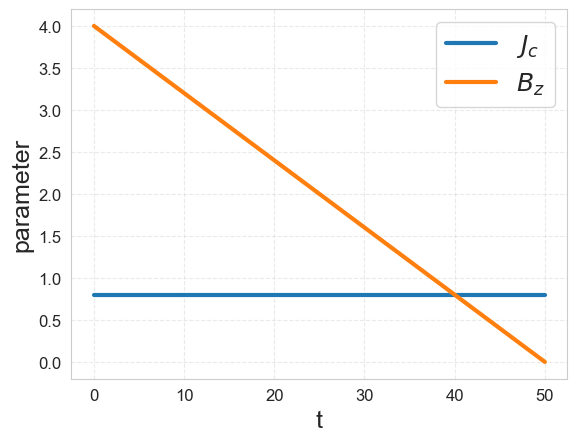

In [51]:
def bath_z_field_zeeman_drive(t, args):
    """Function B(t)"""
    TT = args['T']
    B_i = args['Bi']
    B_f = args['Bf']

    return (((B_f - B_i)/(TT)) * t + B_i)




def coupling_drive(t, args):
    """Function g(t)"""
    TT = args['T']
    J_c = args['Jc']

    return J_c        



plt.plot(times, [coupling_drive(t, time_dependant_functions_coeffs) for t in times], label=r'$J_c$', lw=3.0)
plt.plot(times, bath_z_field_zeeman_drive(times, time_dependant_functions_coeffs), label=r'$B_z$', lw=3.0)
plt.xlabel('t', fontsize = 18)
plt.ylabel('parameter', fontsize = 18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=18)
plt.grid(linestyle='--', alpha=0.4)

In [52]:
#  Open system collapse operators 


def collapse_operators(L, gamma0=0.05):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))


    gamma_list = np.ones(N) * gamma0

    coll_ops = [gamma_list[i] * sz_list[i] for i in range(N)]

    return coll_ops

In [53]:
# Operators

def tfim_sigmax_magnetisation(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    Mx = 0
    
    for n in range(L):
        Mx+=sx_list[n]
    
    return Mx
    


def tfim_magnetisation(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L):
        M+=sz_list[n]
    
    return M

def tfim_magnetisation_x(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L):
        M+=sx_list[n]
    
    return M


def bath_magnetisation(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L, 2*L):
        M+=sz_list[n]
    
    return M

def bath_magnetisation_x(L):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))
    
    M = 0
    
    for n in range(L, 2*L):
        M+=sx_list[n]
    
    return M



def tfim_hamiltonian(L, tfim_params):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    # Ising model hamiltonian construction
    J, hx, hz = tfim_params

    J_list = np.ones(L) * J
    hx_list = np.ones(L) * hx
    hz_list = np.ones(L) * hz

    H_ising_chain = 0

    for n in range(L):
        H_ising_chain += -hx_list[n] * sx_list[n]
        H_ising_chain += -hz_list[n] * sz_list[n]

    for n in range(L):
        H_ising_chain += - J_list[n] * sz_list[n] * sz_list[((n+1)%L)]

    return H_ising_chain


    





In [54]:
def run_cycle(L, tfim_params, bath_params, coupling_params, psi0, tlist):


    sx_list = []
    sy_list = []
    sz_list = []


    N = 2*L

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    # Ising model hamiltonian construction
    J, hx, hz = tfim_params

    J_list = np.ones(L) * J
    hx_list = np.ones(L) * hx
    hz_list = np.ones(L) * hz

    H_ising_chain = 0

    for n in range(L):
        H_ising_chain += -hx_list[n] * sx_list[n]
        H_ising_chain += -hz_list[n] * sz_list[n]

    for n in range(L):
        H_ising_chain += - J_list[n] * sz_list[n] * sz_list[((n+1)%L)]


    # bath x-field hamiltonian construction
    hb, Bi, Bf, T = bath_params

    hb_bath_list = np.ones(L) * hb
    
    H_bath_x_field = 0

    for m in range(L):
        H_bath_x_field += hb_bath_list[m] * sx_list[m+L]


    # bath z-field hamiltonian construction
     
    H_bath_z_field = 0
    
    for m in range(L):
        H_bath_z_field -= sz_list[m+L]


    def bath_z_field_zeeman_drive(t, args):
        """Function B(t)"""
        TT = args['T']
        B_i = args['Bi']
        B_f = args['Bf']

        return (((B_f - B_i)/(TT)) * t + B_i)


    # bath_system coupling hamiltonian construction

    jc, T = coupling_params

    H_coupling = 0
    
    for n in range(L):
        H_coupling += sz_list[n] * sz_list[n+L]

    
    def coupling_drive(t, args):
        """Function Jc(t)"""
        TT = args['T']
        j_c = args['Jc']

        return j_c 

    # Constructing the whole hamiltonian

    time_dependant_functions_coeffs = {'Jc': jc, 'T': T, 'Bi': Bi, 'Bf': Bf}
    
    H = [H_ising_chain, H_bath_x_field, [H_bath_z_field, bath_z_field_zeeman_drive], [H_coupling, coupling_drive]]

    if open_dynamics:
        col_ops = collapse_operators(L)
    else:
        col_ops = []

    # Running the time evolution

    result = qt.mesolve(H, psi0, tlist, c_ops=col_ops, e_ops=[], args=time_dependant_functions_coeffs)

    return result

In [55]:
# calculating the ground state energy of the TFIM

H_TFIM = tfim_hamiltonian(L, tfim_parameters)
M_TFIM = tfim_magnetisation(L)

eigen_energies = H_TFIM.eigenenergies()

E0 = eigen_energies[0]
print("TFIM ground energy: ", E0)

TFIM ground energy:  -6.464101615137763


In [56]:
def run_procedure(error_percentage):

    # Setting up the inital states

    bath_fully_polarized_state = qt.tensor([qt.basis(2,0) for i in range(L)])
    bath_fully_polarized_density_matrix = bath_fully_polarized_state * bath_fully_polarized_state.dag()

    random_tfim_state = qt.tensor([qt.rand_ket(2) for i in range(L)])
    neel_state = qt.tensor([qt.basis(2,i%2) for i in range(L)])

    inital_state = qt.tensor([neel_state, bath_fully_polarized_state])
    #inital_state = qt.tensor([random_tfim_state, bath_fully_polarized_state])

    # Setting for the changing of parameters cycle to cycle

    if couplings_decrease:
        couplings = [-0.5*Jc*i/N_cycles + Jc for i in range(N_cycles)]
    else:
        couplings = [Jc for i in range(N_cycles)]

    if hb_decrease:
        hb_fields = [-0.5*hb*i/N_cycles + hb for i in range(N_cycles)]
    else:
        hb_fields = [hb for i in range(N_cycles)]


    end_of_process_tfim_energies = []
    whole_process_energies = []
    whole_process_entropies = []
    whole_process_tfim_magnetisations = []
    whole_process_bath_magnetisations = []
    whole_process_tfim_magnetisations_x_direction = []
    whole_process_bath_magnetisations_x_direction = []

    # Main loop

    for k in tqdm(range(N_cycles), leave = False):
        
        coupling_parameters = [couplings[k], T]
        bath_parameters = [hb_fields[k], Bi, Bf, T]

        
        
        cycle_result = run_cycle(L, tfim_parameters, bath_parameters, coupling_parameters, inital_state, times)     # Runing a single cycle
        cycle_states = cycle_result.states
        cycle_tfim_energy = qt.expect(H_TFIM, cycle_states)
        whole_process_energies.append(cycle_tfim_energy)

        tfim_cycle_states = [st.ptrace([i for i in range(L)]) for st in cycle_states]
        whole_process_entropies.append([qt.entropy_vn(st * st.dag()) for st in tfim_cycle_states])

        whole_process_tfim_magnetisations.append(qt.expect(tfim_magnetisation(L), cycle_states) / L)
        whole_process_tfim_magnetisations_x_direction.append(qt.expect(tfim_magnetisation_x(L), cycle_states) / L)
        whole_process_bath_magnetisations.append(qt.expect(bath_magnetisation(L), cycle_states) / L)
        whole_process_bath_magnetisations_x_direction.append(qt.expect(bath_magnetisation_x(L), cycle_states) / L)

        
        end_of_process_tfim_energies.append(cycle_tfim_energy[-1])

        end_cycle_state = cycle_states[-1]
        end_cycle_state = end_cycle_state.tidyup()

        if end_of_cycle_measurement:

            mag, after_measure_state = qt.measurement.measure_observable(end_cycle_state, tfim_magnetisation(L))
            tfim_part_of_the_end_cycle_state_density_matrix = after_measure_state.ptrace([i for i in range(L)])
            tfim_part_of_the_end_cycle_state = qt.Qobj((tfim_part_of_the_end_cycle_state_density_matrix.diag()), dims=[[2 for i in range(L)], [1 for i in range(L)]])

            inital_state = qt.tensor([tfim_part_of_the_end_cycle_state, bath_fully_polarized_state])

        elif remake_product_state: 
            tfim_part_of_the_end_cycle_state_density_matrix = end_cycle_state.ptrace([i for i in range(L)])
            
            from pulses_lib import reconstruct_state_L1
            reconstructed_state = reconstruct_state_L1(tfim_part_of_the_end_cycle_state_density_matrix)

            inital_state = qt.tensor([reconstructed_state, bath_fully_polarized_density_matrix])

        elif remake_product_state_LSQ: 
            tfim_part_of_the_end_cycle_state_density_matrix = end_cycle_state.ptrace([i for i in range(L)])
            
            from pulses_lib import reconstruct_state_L1_LSQ
            reconstructed_state = reconstruct_state_L1_LSQ(tfim_part_of_the_end_cycle_state_density_matrix)

            inital_state = qt.tensor([reconstructed_state, bath_fully_polarized_density_matrix])

        elif pass_directly_with_added_errors:
            m_part_of_the_end_cycle_state_density_matrix = end_cycle_state.ptrace([i for i in range(L)])
            random_state = qt.tensor([qt.rand_ket(2) for i in range(L)])
            random_state = random_state * random_state.dag()

            keep_amount = 1-error_percentage

            tfim_new = np.sqrt(keep_amount) * m_part_of_the_end_cycle_state_density_matrix + np.sqrt(1-keep_amount) * random_state

            inital_state = qt.tensor([tfim_new, bath_fully_polarized_density_matrix])

        else:

            tfim_part_of_the_end_cycle_state_density_matrix = end_cycle_state.ptrace([i for i in range(L)])
            inital_state = qt.tensor([tfim_part_of_the_end_cycle_state_density_matrix, bath_fully_polarized_density_matrix])

    return end_of_process_tfim_energies

N_cycles = 200

end_of_cycle_measurement = False         
pass_directly_with_added_errors = False
remake_product_state = False

print(1)


end_of_cycle_measurement = True
measure_procedure = run_procedure(0)
end_of_cycle_measurement = False


print(2)

ideal_procedure = run_procedure(0)


print(3)

remake_product_state = True
reconstructed_procedure = run_procedure(0)
remake_product_state = False


print(4)

remake_product_state_LSQ = True
reconstructed_procedure_LSQ = run_procedure(0)
remake_product_state_LSQ = False




1


  0%|          | 0/200 [00:00<?, ?it/s]

2


  0%|          | 0/200 [00:00<?, ?it/s]

3


  0%|          | 0/200 [00:00<?, ?it/s]

4


  0%|          | 0/200 [00:00<?, ?it/s]

-0.06162400489311371 pi
0.6489873608234649 pi
0.20339142559035953 pi
0.3567776831004263 pi
-0.06162400297983123 pi
0.6489873608637937 pi
-0.0005146452991154986 pi
0.3442056712491121 pi
-0.0317333585072856 pi
0.5004084097278606 pi
-0.0005146462484090527 pi
0.3442056712804506 pi
-0.019023153597236043 pi
0.34201325433687135 pi
-0.0490358490506183 pi
0.25512548832847337 pi
-0.019023153369063864 pi
0.3420132539484922 pi
-0.059237133005598484 pi
0.2889296793408134 pi
-0.019392396573107026 pi
0.3250552237721545 pi
-0.05923713353323197 pi
0.28892967983370393 pi
-0.057455416753473695 pi
0.3283306878018005 pi
-0.08507631719231008 pi
0.3202671981298136 pi
-0.057455416840992625 pi
0.32833068796061793 pi
-0.09482723526316249 pi
0.38394583280291156 pi
-0.08399815140934315 pi
0.378835810636721 pi
-0.0948272360987405 pi
0.3839458321654501 pi
-0.11198458918837464 pi
0.4857720965109872 pi
-0.11067799921910876 pi
0.4919432617402487 pi
-0.11198458879727692 pi
0.4857720963281104 pi
-0.10400393813544323 pi


  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'L=3, $\\delta t$=0.1, T=50.0, J=1, $h_x$=2, $J_c$=0.8, $B_i$=4.0, $B_f$=0.0, $h_b$=0.8')

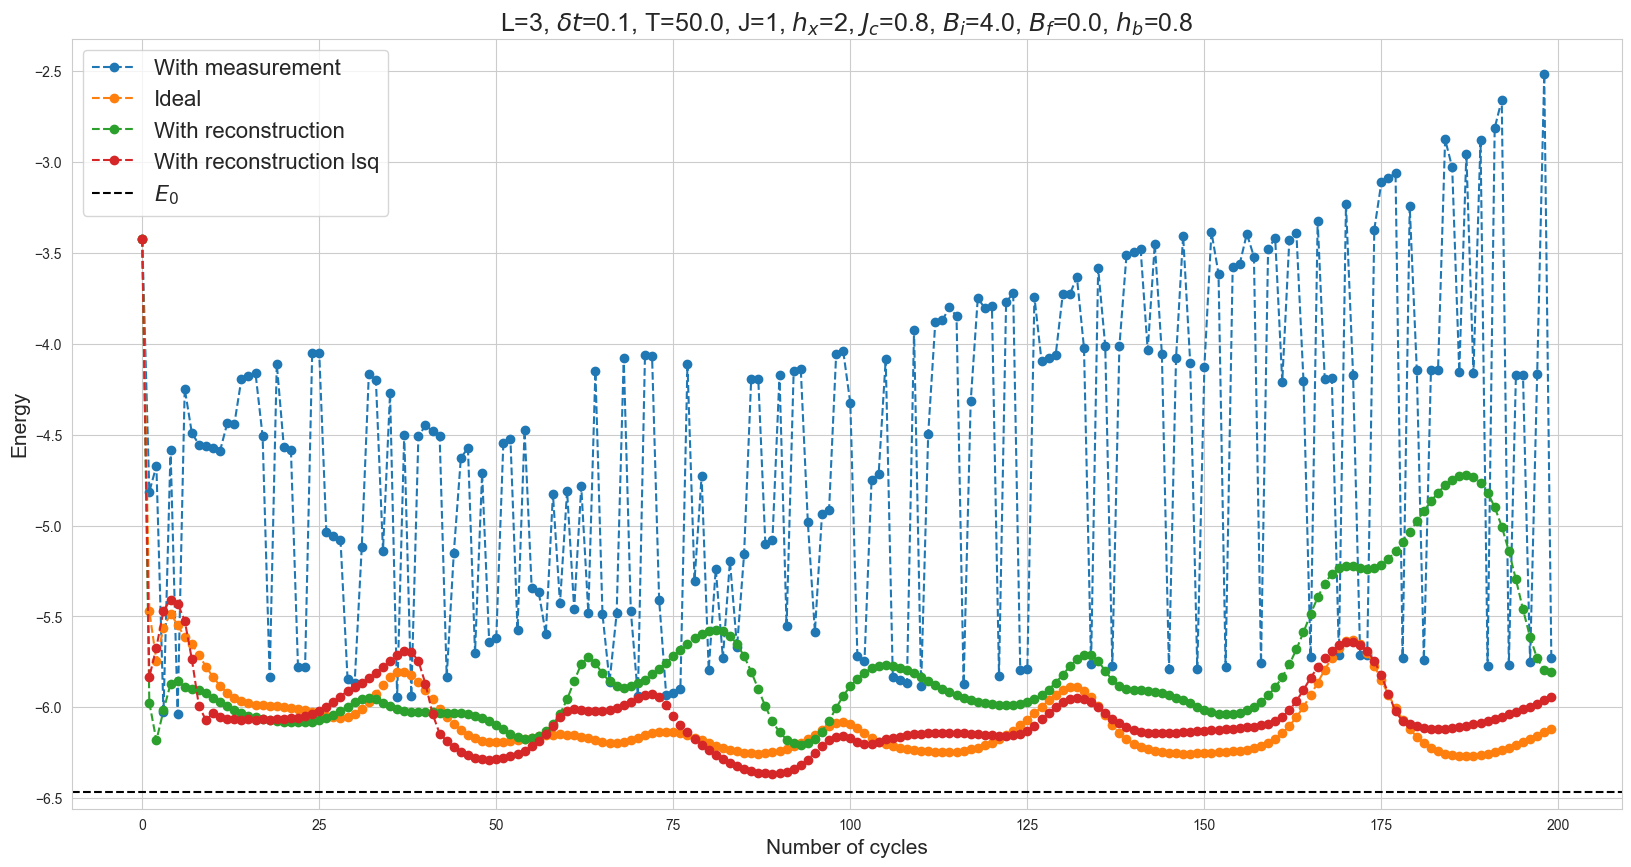

In [57]:
plt.figure(figsize=(20,10))

for i in tqdm(range(1)):
    plt.plot(measure_procedure, '--o', label="With measurement")
    plt.plot(ideal_procedure, '--o', label="Ideal")
    plt.plot(reconstructed_procedure, '--o', label="With reconstruction")
    plt.plot(reconstructed_procedure_LSQ, '--o', label="With reconstruction lsq")

plt.axhline(y=E0, linestyle='--', color='black', label=r"$E_0$")

plt.legend(fontsize = 16)
plt.xlabel('Number of cycles', fontsize = 15)
plt.ylabel('Energy', fontsize = 15)
plt.title(fr'L={L}, $\delta t$={dt}, T={T}, J={J}, $h_x$={hx}, $J_c$={Jc}, $B_i$={Bi}, $B_f$={Bf}, $h_b$={hb}', fontsize = 18) 